In [1]:
import os
import word2vec
import pandas as pd
import numpy as np

## Download toy corpus for wordvector training and example text

In [ ]:
corpus_path = './text8'
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

link = 'https://www.gutenberg.org/files/98/98-0.txt'  # a tale of two cities
# link = 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'  # siddartha
text_path = link.split('/')[-1]
if not os.path.exists(text_path):
    !wget {link}

## Train wordvectors

In [2]:
wrdvec_path = './wrdvecs_100.bin'
if not os.path.exists(wrdvec_path):
    %time word2vec.word2vec(corpus_path, wrdvec_path, iter_=5, hs=1, threads=4, sample='1e-5', window=10, size=100, binary=1)

In [3]:
model = word2vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.vectors, index=model.vocab)
print(wrdvecs.shape)

(71291, 100)


## run get_penalty and split_optimal

In [6]:
from textsplit.tools import sentences_iter, sentences_vectors_iter, split_texts_optimal
from textsplit.algorithm import get_penalty

with open(text_path, 'rt') as f:
    text = f.read().replace('\n', ' ')

texts = [text]
sentenced_texts = sentences_iter(texts)
sentences_vectors_texts = list(sentences_vectors_iter(sentenced_texts, wrdvecs))

vectors_texts = [vectors for _, vectors in sentences_vectors_texts]
penalty = get_penalty(vectors_texts, 10)  # segment target length in sentences

%time segmented_texts = list(split_texts_optimal(sentences_vectors_texts, penalty, seg_limit=100))

n_sentences = vectors_texts[0].shape[0]
n_segments = len(segmented_texts[0])
print('%d sentences, %d segments, avg %4.2f sentences per segment' % (n_sentences, n_segments, n_sentences/n_segments))

CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 412 ms
5738 sentences, 685 segments, avg 8.38 sentences per segment


## print example text with segment and sentence annotation

In [ ]:
for segment_sentences in segmented_texts[0]:
    segment_str = ' // '.join(segment_sentences)
    segment_str += '\n[%d sentences]' % len(segment_sentences)
    print('%s\n--------------------------------------' % segment_str)

## compare segment lenghts of greedy and optimal algorithm

CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 109 ms


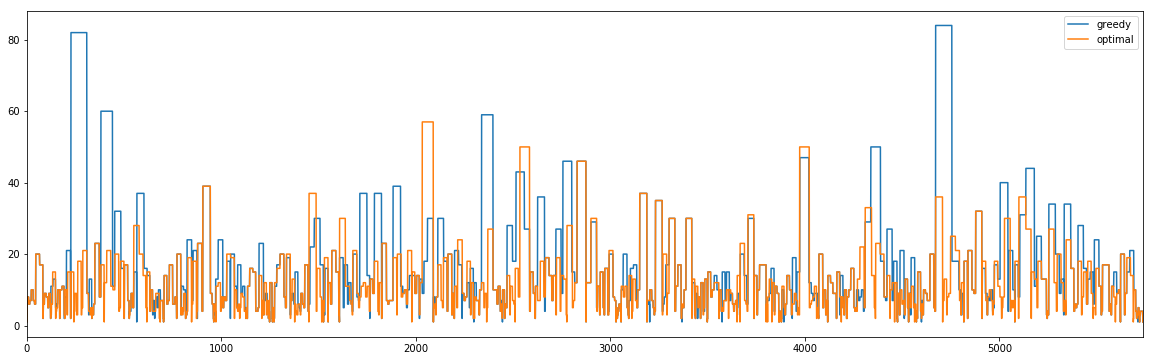

In [5]:
%matplotlib inline
from textsplit.tools import split_texts_greedy
%time segmented_texts_greedy = list(split_texts_greedy(sentences_vectors_texts, penalty))
lengths_optimal = [len(segment) for segment in segmented_texts[0] for sentence in segment]
lengths_greedy = [len(segment) for segment in segmented_texts_greedy[0] for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(20,6))